In [35]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as rand

In [36]:
import sys
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/mnist3')

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 28 * 28
hidden_size = 100
num_classes = 10
epochs = 2
batch_size = 100
learning_rate = 0.001

In [38]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([100, 1, 28, 28]) torch.Size([100])


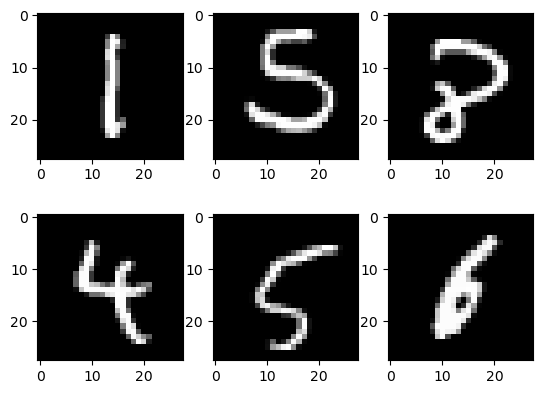

In [39]:
examples = iter(train_loader)
samples, labels = examples.__next__()
print(samples.shape, labels.shape)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(rand.choice(samples)[0], cmap='gray')

plt.show()

In [40]:
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()

In [41]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)

        return out


model = Model(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [42]:
writer.add_graph(model, samples.reshape(-1, 28 * 28))
writer.close()

In [43]:
total = len(train_loader)
step = 0.1 * total

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        pred = model(images)

        loss = criterion(pred, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(pred, 1)
        running_correct += (predictions == labels).sum().item()

        if (i + 1) % step == 0:
            print(f"epoch:{epoch + 1}/{epochs}, iter:{i}/{total}, loss:{loss.item():.4f}")
            writer.add_scalar('training loss', running_loss / 100, epoch * total + i)
            writer.add_scalar('accuracy', running_correct / 100, epoch * total + i)
            running_loss = 0.0
            running_correct = 0

epoch:1/2, iter:59/600, loss:0.5817
epoch:1/2, iter:119/600, loss:0.5085
epoch:1/2, iter:179/600, loss:0.3656
epoch:1/2, iter:239/600, loss:0.2866
epoch:1/2, iter:299/600, loss:0.3234
epoch:1/2, iter:359/600, loss:0.3069
epoch:1/2, iter:419/600, loss:0.1868
epoch:1/2, iter:479/600, loss:0.3101
epoch:1/2, iter:539/600, loss:0.1792
epoch:1/2, iter:599/600, loss:0.2637
epoch:2/2, iter:59/600, loss:0.3187
epoch:2/2, iter:119/600, loss:0.1953
epoch:2/2, iter:179/600, loss:0.1463
epoch:2/2, iter:239/600, loss:0.1499
epoch:2/2, iter:299/600, loss:0.2382
epoch:2/2, iter:359/600, loss:0.1552
epoch:2/2, iter:419/600, loss:0.1297
epoch:2/2, iter:479/600, loss:0.1470
epoch:2/2, iter:539/600, loss:0.1900
epoch:2/2, iter:599/600, loss:0.1327


In [44]:
# test

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)

        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

    acc = 100 * n_correct / n_samples
    print(f"accuracy = {acc}")


accuracy = 95.43
